# Import Statements

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# Agents

## Doctor

In [65]:
class Doctor:
    
    
    def __init__(self, doctor_id, rating_manager=None):
        self.doctor_id = doctor_id
        self.experience = 0  # Initialize experience to zero
        self.research_ability = random.uniform(0.2,0.6)  # Initial random value for research ability
        self.empathy = random.uniform(0.2,0.7)  # Initial random value for empathy
        self.personal_resource_constraint = 0.8  # Personal constraint on ability development
        self.personal_resource = 1 - self.personal_resource_constraint  # Personal resource available for ability development
        self.technological_resource_constraint = random.uniform(0.2,0.5) # External constraint, affects treatment effectiveness
        self.credential = random.choice(['low', 'medium', 'high'])  # Random initial credential
        self.is_busy = False  # Doctor is not busy initially
        self.rating_manager = rating_manager  # Rating manager to get patient ratings
    
    def start_treatment(self):
        self.is_busy = True
        
    
    def end_treatment(self):
        self.is_busy = False

    
    def treat_patient(self):
        """Calculate the treatment effectiveness first before updating the doctor's experience and abilities."""
        if self.is_busy:
            return 0
        self.start_treatment()
        effectiveness = self.calculate_treatment_effectiveness()
        self.update_experience_and_abilities()  # Now update experience and abilities
        # self.end_treatment()
        return effectiveness
    
    
    def update_experience_and_abilities(self):
        """Update the doctor's experience and abilities after treating a patient."""
        self.experience += 1
        self.upgrade_credential()
    
    

    def upgrade_credential(self):
        """Upgrade credentials based on experience and research ability."""
        if self.credential == 'low' and (self.research_ability >= 0.5):
            self.credential = 'medium'
        elif self.credential == 'medium' and (self.research_ability >= 0.8):
            self.credential = 'high'
            
    
    def calculate_treatment_effectiveness(self):
        """Calculate treatment effectiveness based on credential, empathy, and technological resource constraint."""
        credential_factor = {'low': 0.1, 'medium': 0.2, 'high': 0.4}
        effectiveness = (credential_factor[self.credential] + self.empathy) * (1 - self.technological_resource_constraint)
        return min(effectiveness, 0.7)
    
    
    def get_experience(self):
        return self.experience
    
    
    def get_id(self):
        return self.doctor_id


    def get_research_ability(self):
        return self.research_ability


    def get_empathy(self):
        return self.empathy


    def get_personal_resource_constraint(self):
        return self.personal_resource_constraint


    def get_technological_resource_constraint(self):
        return self.technological_resource_constraint


    def get_credential(self):
        return self.credential
    
    
# Codes for implementing the genetic algorithm
    
    def mutate(doctor):
        # Retrieve recent feedback to decide on the mutation strength
        recent_feedback = doctor.rating_manager.get_recent_feedback(doctor.doctor_id)
        mutation_factor = 1.5 if recent_feedback < 3 else 0.5  # Example threshold

        mutation_amount = min(doctor.personal_resource, random.uniform(0, 0.05)) * mutation_factor
        trait_to_mutate = random.random()
        
        change = mutation_amount * random.choice([-1, 1])
        if trait_to_mutate < 0.5:
            doctor.research_ability += change
            doctor.research_ability = max(0, min(doctor.research_ability, 1))
        else:
            doctor.empathy += change
            doctor.empathy = max(0, min(doctor.empathy, 1))
            
        doctor.personal_resource -= mutation_amount

        
    
    def calculate_fitness(self):
        """Calculate fitness based on multiple factors."""
        base_fitness = self.rating_manager.get_mean_rating(self.doctor_id) if self.rating_manager else 0
        # Add a weighted contribution from research ability and empathy
        return base_fitness 
    # + 0. * self.research_ability + 0.1 * self.empathy

    
    
    def crossover(self, other):
        """Performs crossover between this doctor and another doctor."""
        if random.random() < 0.5:  # Optionally perform crossover with a 50% chance
            # Averaging crossover for demonstration
            self.research_ability = (self.research_ability + other.research_ability) / 2
            self.empathy = (self.empathy + other.empathy) / 2


    def log_status(self):
        """Logs the current status of the doctor for debugging and analysis purposes."""
        print(f"Doctor {self.doctor_id}: Experience = {self.experience}, "
              f"Research Ability = {self.research_ability:.2f}, "
              f"Empathy = {self.empathy:.2f}")




## Patient

In [66]:
class Patient:
    
    
    def __init__(self, patient_id, rating_manager):
        self.patient_id = patient_id
        self.health_levels = []  # List to store health levels over time
        self.health_level = random.uniform(0.5, 1.0)  # Initialize with a random health level
        self.health_levels.append(self.health_level)  # Add initial health level to history
        self.rating_manager = rating_manager
        self.is_infected = False  # Initialize patient as not infected
        self.last_doctor_id = None # Initialize last doctor ID to None
        self.infected_order = None # Initialize infected order to None
        self.resilience = random.uniform(0.1, 0.4)  # Random resilience factor

        # Initialize judgment weights randomly to allow for genetic diversity
        self.cred_weight = random.uniform(0.1, 0.4)
        self.mean_rating_weight = random.uniform(0.1, 0.4)
        self.past_rating_weight = 1 - (self.cred_weight + self.mean_rating_weight)
        
        
    #TODO: Why am I checking if self.health_level > 0.1?   
    def infect(self, order):
        # reduce health due to an infection, if not already infected 
        if not self.is_infected and self.health_level > 0.1:
            infection_severity = 0.1
            self.health_level = self.health_level - infection_severity
            self.is_infected = True
            self.infected_order = order
            print(f"Patient {self.patient_id} has been infected and is number {order} in line. Health level reduced to {self.health_level:.2f}")
            
    
    def priority(self):
        """Return a tuple that represents the patient's priority for treatment."""
        # Patients with lower health or who are infected have higher priority
        return (not self.is_infected, self.infected_order if self.infected_order is not None else float('inf'), self.health_level)
            
          
    def needs_doctor(self):
        """Check if patient needs a doctor based on health level"""
        return self.health_level < 0.6
    
    
    def judge_doctor(self, doctor):
        """Compute judgment using doctor's credentials, mean rating, and personal past rating."""
        credential_score = {'low': 0.1, 'medium': 0.5, 'high': 1.0}[doctor.get_credential()]
        mean_rating = self.rating_manager.get_mean_rating(doctor.get_id())
        past_rating = self.rating_manager.get_rating_by_patient(doctor.get_id(), self.patient_id) or 0
        judgment = self.cred_weight * credential_score + self.mean_rating_weight * mean_rating + self.past_rating_weight * past_rating
        return judgment
    
    # TODO: Check the logic of the choice, especially how the last doctor is judged and chosen
    def choose_doctor(self, doctors):
        """Choose a doctor based on availability, past experiences, or judgment if no satisfactory treatment previously."""
        if self.needs_doctor():
            # Filter out doctors who are busy
            available_doctors = [doc for doc in doctors if not doc.is_busy]
            
            if not available_doctors:
                print(f"No available doctors for patient {self.patient_id} at this time.")
                return None
            
            # Continue with the same doctor if they previously received a perfect rating and are available
            if self.last_doctor_id and self.rating_manager.get_rating_by_patient(self.last_doctor_id, self.patient_id) == 5:
                for doc in available_doctors:
                    if doc.get_id() == self.last_doctor_id:
                        return doc
            
            # Choose a new doctor based on judgment, excluding the last doctor if not rated 5
            eligible_doctors = [doc for doc in available_doctors if doc.get_id() != self.last_doctor_id or self.rating_manager.get_rating_by_patient(doc.get_id(), self.patient_id) != 5]
            if eligible_doctors:
                return max(eligible_doctors, key=lambda doc: self.judge_doctor(doc))
            else:
                # This else block might not be necessary anymore if all doctors are busy, but keeping for robustness
                return max(available_doctors, key=lambda doc: self.judge_doctor(doc))
        return None



    def treat_infection(self):
        """Mark patient as not infected"""
        self.is_infected = False
        
    
    def receive_treatment(self, doctor):
        """The patient receives treatment and then the doctor updates their experience."""
        effectiveness = doctor.treat_patient() * (1 - self.resilience)  # Get the effectiveness based on the doctor's current state
        self.update_health_level(effectiveness)  # Update health level based on this effectiveness
        self.treat_infection()  # Mark patient as not infected
        rating = self.rate_doctor(doctor)  # Rate the doctor
        print(f"Patient {self.patient_id} treated by Doctor {doctor.get_id()}, rating: {rating}. Health: {self.health_level:.2f}")
        return rating
     
    
    def update_health_level(self, effectiveness):
            """Update the health level based on the treatment effectiveness."""
            self.health_level = max(0.1, min(1, self.health_level + effectiveness))
            self.health_levels.append(self.health_level)  # Update health history
            
    
    def calculate_average_health(self):
        """Calculate the average health from the health history."""
        if self.health_levels:
            return sum(self.health_levels) / len(self.health_levels)
        return 0


    def rate_doctor(self, doctor):
        
        """Rate the doctor based on the treatment's effectiveness."""
        if self.health_level >= 0.8:
            rating = 5
        else:
            rating = max(0, int(5 * (self.health_level / 0.8)))
            
        self.rating_manager.add_rating(doctor.get_id(), self.patient_id, rating)
        
        self.last_doctor_id = doctor.get_id()
        
        # print(f"Patient {self.patient_id} treated by Doctor {doctor.get_id()}, rating: {rating}. Health: {self.health_level:.2f}")
            
        return rating
    
    
    #Codes for implementing the genetic algorithm
    
    
    def mutate_judgment_traits(self):
        # Randomly mutate the judgment weights and resilience
        mutation_amount = random.uniform(-0.05, 0.05)
        self.cred_weight += mutation_amount
        self.mean_rating_weight += mutation_amount
        self.past_rating_weight -= 2 * mutation_amount  # Adjust to keep the sum unchanged
        self.resilience += random.uniform(-0.05, 0.05)  # Mutate resilience within a small range
        
        # Ensure weights are non-negative before normalization
        self.cred_weight = max(0, self.cred_weight)
        self.mean_rating_weight = max(0, self.mean_rating_weight)
        self.past_rating_weight = max(0, self.past_rating_weight)

        # Normalize judgment weights to ensure they sum to 1 and are within bounds
        total = self.cred_weight + self.mean_rating_weight + self.past_rating_weight
        if total > 0:
            self.cred_weight /= total
            self.mean_rating_weight /= total
            self.past_rating_weight /= total
        else:
            # Reset to equal distribution if total is 0
            self.cred_weight = self.mean_rating_weight = self.past_rating_weight = 1 / 3

        # Ensure all weights and resilience are within valid bounds
        self.cred_weight = max(0, min(self.cred_weight, 1))
        self.mean_rating_weight = max(0, min(self.mean_rating_weight, 1))
        self.past_rating_weight = max(0, min(self.past_rating_weight, 1))
        self.resilience = max(0.1, min(self.resilience, 0.4))  # Ensure resilience stays within the initialized range
        
        
    def crossover(self, other):
        if random.random() < 0.5:  # Perform crossover with a 50% chance
            # Averaging crossover for demonstration
            self.resilience = (self.resilience + other.resilience) / 2
            self.cred_weight = (self.cred_weight + other.cred_weight) / 2
            self.mean_rating_weight = (self.mean_rating_weight + other.mean_rating_weight) / 2
            self.past_rating_weight = (self.past_rating_weight + other.past_rating_weight) / 2

            # Normalize judgment weights to ensure they sum to 1
            total = self.cred_weight + self.mean_rating_weight + self.past_rating_weight
            if total > 0:
                self.cred_weight /= total
                self.mean_rating_weight /= total
                self.past_rating_weight /= total


    def calculate_fitness(self):
        """Calculate fitness based on the average health level."""
        return self.calculate_average_health()

    
    def log_status(self):
        """Logs the current status of the patient for debugging and analysis purposes."""
        print(f"Patient {self.patient_id}: Health Level = {self.health_level:.2f}, "
              f"Resilience = {self.resilience:.2f}, "
              f"Infection Status = {'Infected' if self.is_infected else 'Not Infected'}, "
              f"Credibility Weight = {self.cred_weight:.2f}, "
              f"Mean Rating Weight = {self.mean_rating_weight:.2f}, "
              f"Past Rating Weight = {self.past_rating_weight:.2f}")

    

## Ratings Manager

In [67]:
from collections import deque

class RatingManager:
    def __init__(self, max_history=5):
        self.ratings = {}
        self.recent_ratings = { }  # Stores recent ratings with deque for each doctor
        self.max_history = max_history  # Maximum history length

    def add_rating(self, doctor_id, patient_id, rating):
        if doctor_id not in self.ratings:
            self.ratings[doctor_id] = {}
            self.recent_ratings[doctor_id] = deque(maxlen=self.max_history)
        self.ratings[doctor_id][patient_id] = rating
        self.recent_ratings[doctor_id].append(rating)  # Add rating to the recent ratings deque

    def get_mean_rating(self, doctor_id):
        if doctor_id in self.ratings and self.ratings[doctor_id]:
            return np.mean(list(self.ratings[doctor_id].values()))
        return 0

    def get_recent_feedback(self, doctor_id):
        """Calculate and return the mean of recent ratings for a specified doctor."""
        if doctor_id in self.recent_ratings and self.recent_ratings[doctor_id]:
            return np.mean(list(self.recent_ratings[doctor_id]))
        return 0

    def get_rating_by_patient(self, doctor_id, patient_id):
        if doctor_id in self.ratings and patient_id in self.ratings[doctor_id]:
            return self.ratings[doctor_id][patient_id]
        return None

    def get_all_ratings(self):
        return self.ratings


## Infection Manager

In [68]:
class InfectionManager:
    def __init__(self, patients):
        self.patients = patients
        self.infection_counter = 0

    def spread_infection(self):
        # Select up to 3 random patients to infect
        candidates = [p for p in self.patients if not p.is_infected and p.health_level > 0.1]
        infectees = random.sample(candidates, min(25, len(candidates)))
        for patient in infectees:
            self.infection_counter += 1
            patient.infect(self.infection_counter)

# Microbial GA Implementation

In [69]:
def select_two_individuals(individuals):
    # Implementing tournament selection
    tournament_size = 5
    tournament = random.sample(individuals, tournament_size)
    tournament_sorted = sorted(tournament, key=lambda x: x.calculate_fitness(), reverse=True)
    return tournament_sorted[0], tournament_sorted[-1]


def mutate(individual):
    mutation_chance = 0.01  # Lowering mutation chance to test its impact
    if random.random() < mutation_chance:
        individual.mutate_judgment_traits() if isinstance(individual, Patient) else individual.mutate()


def crossover(individual1, individual2):
    if random.random() < 0.5:  # Crossover probability
        individual1.crossover(individual2)


def preserve_elites(individuals, num_elites=2):
    elites = sorted(individuals, key=lambda x: x.calculate_fitness(), reverse=True)[:num_elites]
    return elites


# Simulation

In [70]:
def run_simulation(num_doctors, num_patients, num_rounds, seed=None):
    if seed is not None:
        random.seed(seed)
    
    rating_manager = RatingManager()
    patients = [Patient(i, rating_manager) for i in range(num_patients)]
    doctors = [Doctor(i, rating_manager) for i in range(num_doctors)]
    infection_manager = InfectionManager(patients)
    
    doctor_fitness_over_time = []
    patient_fitness_over_time = []
    doctor_research_ability_over_time = []
    doctor_empathy_over_time = []
    patient_cred_weight_over_time = []
    patient_mean_rating_weight_over_time = []
    patient_past_rating_weight_over_time = []
    patient_resilience_over_time = []  # New tracking for resilience
    
    for round in range(num_rounds):
        print(f"--- Simulation Round {round + 1} ---")
        infection_manager.spread_infection()
        
        for doctor in doctors:
            doctor.is_busy = False

        priority_patients = sorted(patients, key=lambda p: p.priority())
        for patient in priority_patients:
            if patient.needs_doctor():
                chosen_doctor = patient.choose_doctor(doctors)
                if chosen_doctor and not chosen_doctor.is_busy:
                    patient.receive_treatment(chosen_doctor)
                else:
                    print(f"Patient {patient.patient_id} needs a doctor! Health: {patient.health_level:.2f}")

        patient_elites = preserve_elites(patients, num_elites=2)
        doctor_elites = preserve_elites(doctors, num_elites=2)

        for _ in range(len(patients) // 2):
            winner, loser = select_two_individuals(patients)
            crossover(winner, loser)
            mutate(loser)
        patients[-2:] = patient_elites

        for _ in range(len(doctors) // 2):
            winner, loser = select_two_individuals(doctors)
            crossover(winner, loser)
            mutate(loser)
        doctors[-2:] = doctor_elites

        avg_doc_fitness = sum(d.calculate_fitness() for d in doctors) / len(doctors)
        avg_pat_fitness = sum(p.calculate_fitness() for p in patients) / len(patients)
        avg_doc_research = sum(d.research_ability for d in doctors) / len(doctors)
        avg_doc_empathy = sum(d.empathy for d in doctors) / len(doctors)
        avg_pat_cred_weight = sum(p.cred_weight for p in patients) / len(patients)
        avg_pat_mean_rating = sum(p.mean_rating_weight for p in patients) / len(patients)
        avg_pat_past_rating = sum(p.past_rating_weight for p in patients) / len(patients)
        avg_pat_resilience = sum(p.resilience for p in patients) / len(patients)  # Calculate resilience

        doctor_fitness_over_time.append(avg_doc_fitness)
        patient_fitness_over_time.append(avg_pat_fitness)
        doctor_research_ability_over_time.append(avg_doc_research)
        doctor_empathy_over_time.append(avg_doc_empathy)
        patient_cred_weight_over_time.append(avg_pat_cred_weight)
        patient_mean_rating_weight_over_time.append(avg_pat_mean_rating)
        patient_past_rating_weight_over_time.append(avg_pat_past_rating)
        patient_resilience_over_time.append(avg_pat_resilience)  # Store resilience

        for patient in random.sample(patients, 2):
            patient.log_status()
        for doctor in random.sample(doctors, 2):
            doctor.log_status()
            
    return (doctor_fitness_over_time, patient_fitness_over_time, 
            doctor_research_ability_over_time, doctor_empathy_over_time, 
            patient_cred_weight_over_time, patient_mean_rating_weight_over_time, 
            patient_past_rating_weight_over_time, patient_resilience_over_time)

# Running the updated simulation
results = run_simulation(15, 100, 15, 42)

--- Simulation Round 1 ---
Patient 62 has been infected and is number 1 in line. Health level reduced to 0.74
Patient 80 has been infected and is number 2 in line. Health level reduced to 0.83
Patient 30 has been infected and is number 3 in line. Health level reduced to 0.78
Patient 35 has been infected and is number 4 in line. Health level reduced to 0.64
Patient 56 has been infected and is number 5 in line. Health level reduced to 0.43
Patient 9 has been infected and is number 6 in line. Health level reduced to 0.81
Patient 91 has been infected and is number 7 in line. Health level reduced to 0.59
Patient 36 has been infected and is number 8 in line. Health level reduced to 0.61
Patient 97 has been infected and is number 9 in line. Health level reduced to 0.87
Patient 34 has been infected and is number 10 in line. Health level reduced to 0.43
Patient 42 has been infected and is number 11 in line. Health level reduced to 0.51
Patient 40 has been infected and is number 12 in line. Heal

# Plotting

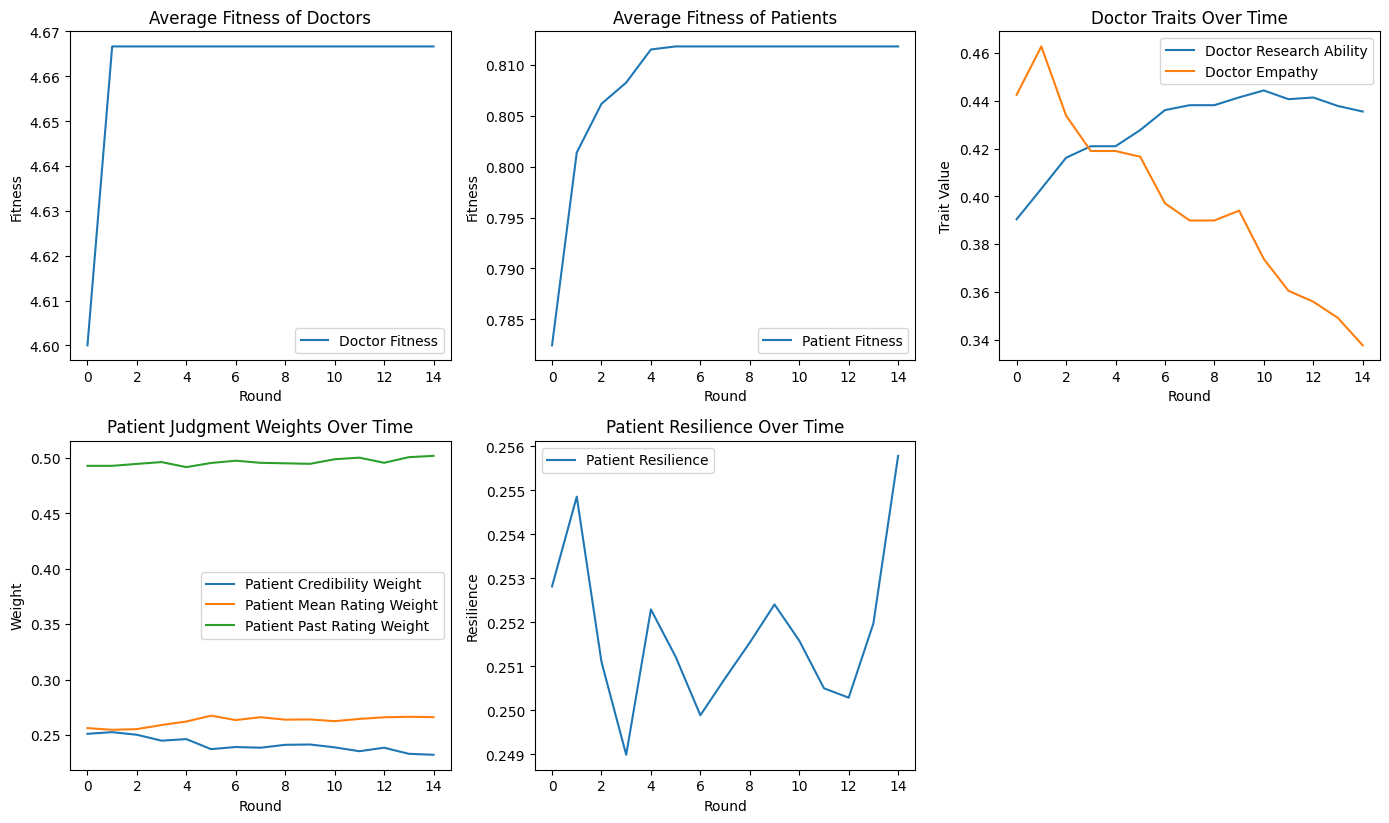

In [71]:
import matplotlib.pyplot as plt

def plot_simulation_results(results):
    # Update unpacking to include the resilience data
    (doctor_fitness, patient_fitness, doctor_research, doctor_empathy, 
     patient_cred, patient_mean_rating, patient_past_rating, patient_resilience) = results

    plt.figure(figsize=(14, 12))  # Increase the figure size to accommodate an extra plot

    # Plot doctor fitness
    plt.subplot(3, 3, 1)
    plt.plot(doctor_fitness, label='Doctor Fitness')
    plt.title('Average Fitness of Doctors')
    plt.xlabel('Round')
    plt.ylabel('Fitness')
    plt.legend()

    # Plot patient fitness
    plt.subplot(3, 3, 2)
    plt.plot(patient_fitness, label='Patient Fitness')
    plt.title('Average Fitness of Patients')
    plt.xlabel('Round')
    plt.ylabel('Fitness')
    plt.legend()

    # Plot doctor traits
    plt.subplot(3, 3, 3)
    plt.plot(doctor_research, label='Doctor Research Ability')
    plt.plot(doctor_empathy, label='Doctor Empathy')
    plt.title('Doctor Traits Over Time')
    plt.xlabel('Round')
    plt.ylabel('Trait Value')
    plt.legend()

    # Plot patient judgment weights
    plt.subplot(3, 3, 4)
    plt.plot(patient_cred, label='Patient Credibility Weight')
    plt.plot(patient_mean_rating, label='Patient Mean Rating Weight')
    plt.plot(patient_past_rating, label='Patient Past Rating Weight')
    plt.title('Patient Judgment Weights Over Time')
    plt.xlabel('Round')
    plt.ylabel('Weight')
    plt.legend()

    # Plot patient resilience
    plt.subplot(3, 3, 5)
    plt.plot(patient_resilience, label='Patient Resilience')
    plt.title('Patient Resilience Over Time')
    plt.xlabel('Round')
    plt.ylabel('Resilience')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the results
plot_simulation_results(results)


--- Simulation Round 1 ---
Patient 62 has been infected and is number 1 in line. Health level reduced to 0.74
Patient 80 has been infected and is number 2 in line. Health level reduced to 0.83
Patient 30 has been infected and is number 3 in line. Health level reduced to 0.78
Patient 35 has been infected and is number 4 in line. Health level reduced to 0.64
Patient 56 has been infected and is number 5 in line. Health level reduced to 0.43
Patient 9 has been infected and is number 6 in line. Health level reduced to 0.81
Patient 91 has been infected and is number 7 in line. Health level reduced to 0.59
Patient 36 has been infected and is number 8 in line. Health level reduced to 0.61
Patient 97 has been infected and is number 9 in line. Health level reduced to 0.87
Patient 34 has been infected and is number 10 in line. Health level reduced to 0.43
Patient 42 has been infected and is number 11 in line. Health level reduced to 0.51
Patient 40 has been infected and is number 12 in line. Heal

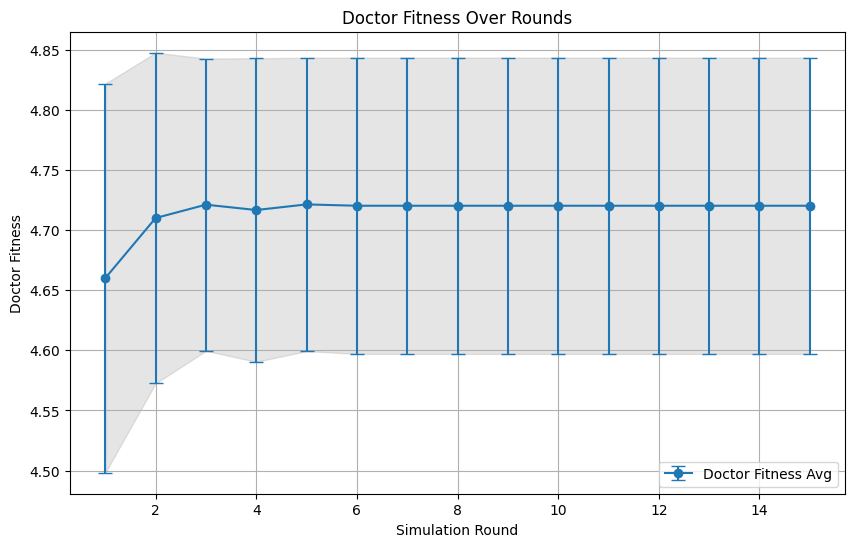

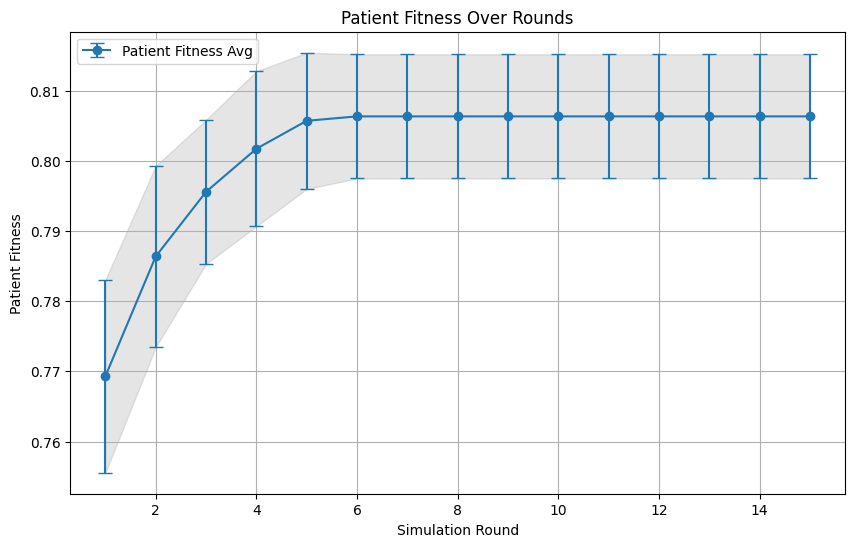

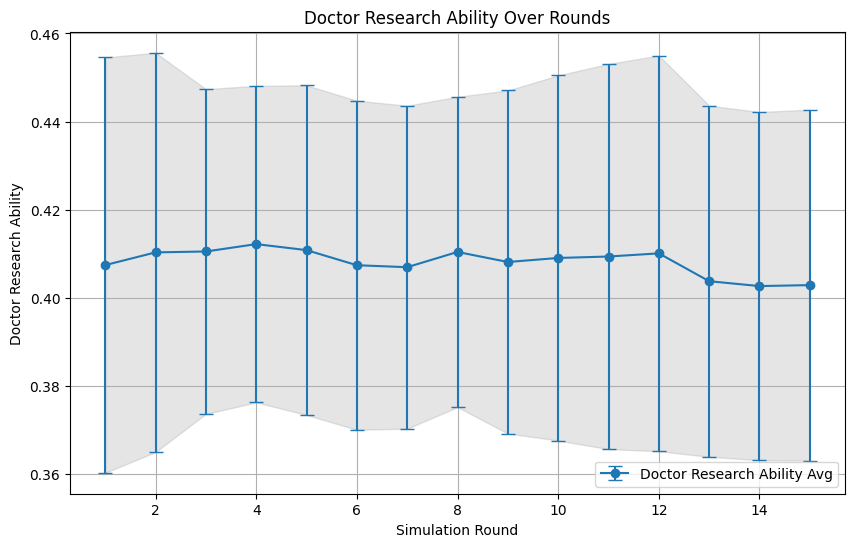

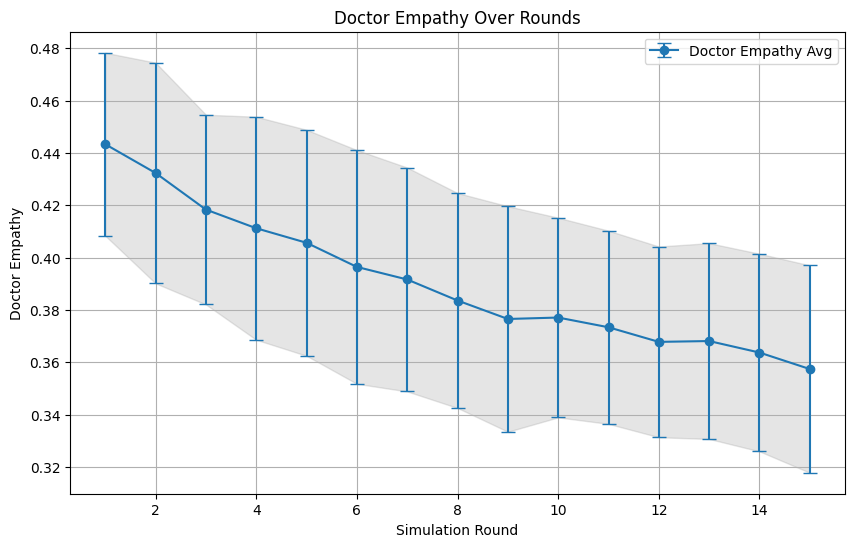

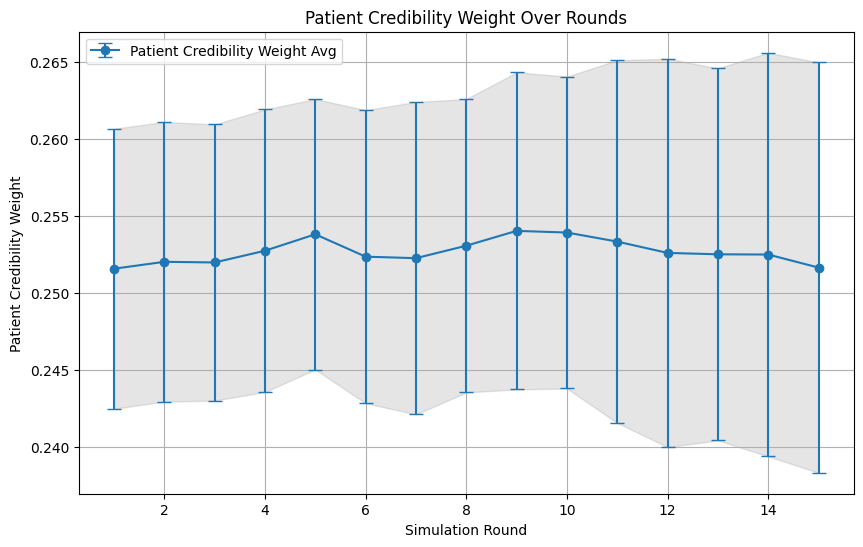

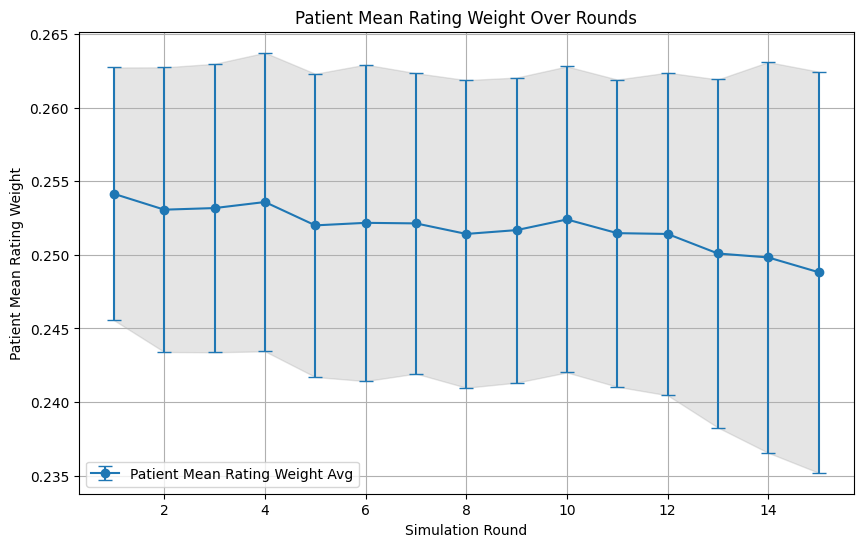

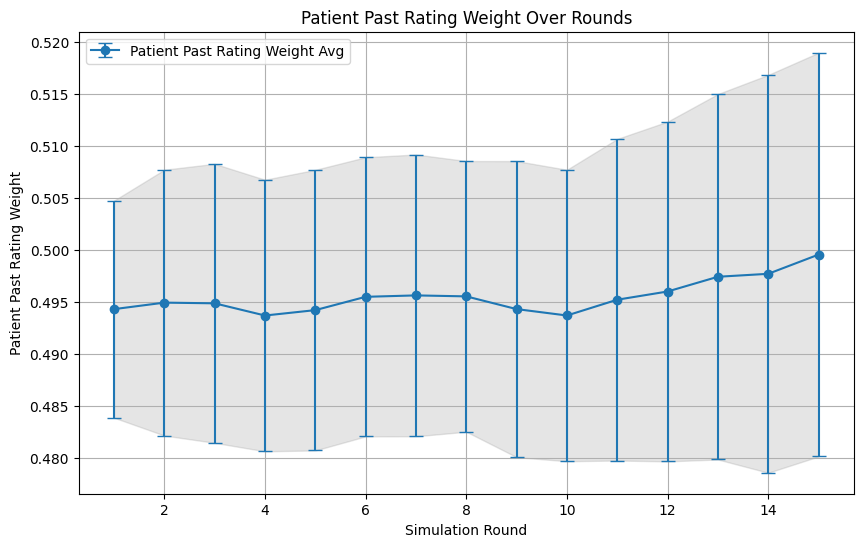

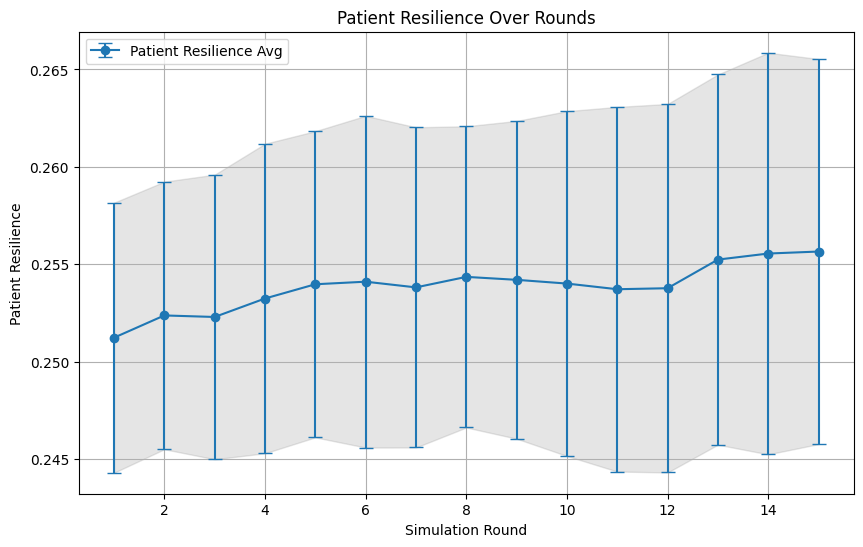

In [72]:
def multiple_simulations(num_doctors, num_patients, num_rounds, num_repetitions=10, seed=None):
    # Initialize lists to store data from each run
    metric_keys = ["Doctor Fitness", "Patient Fitness", "Doctor Research Ability", "Doctor Empathy", 
                   "Patient Credibility Weight", "Patient Mean Rating Weight", "Patient Past Rating Weight",
                   "Patient Resilience"]
    all_data = [[] for _ in range(len(metric_keys))]  # Adjust to the number of metrics

    for n in range(num_repetitions):
        if seed is not None:
            # Set a unique seed for each repetition if a base seed is provided
            random.seed(seed + n)

        # Run the simulation and collect data
        data = run_simulation(num_doctors, num_patients, num_rounds)
        for i in range(len(metric_keys)):  # Ensure correct indexing
            all_data[i].append(data[i])

    # Calculate mean and std dev for each metric across repetitions for each round
    means = []
    std_devs = []
    for metric_data in all_data:
        metric_means = [np.mean(round_data) for round_data in zip(*metric_data)]
        metric_stds = [np.std(round_data) for round_data in zip(*metric_data)]
        means.append(metric_means)
        std_devs.append(metric_stds)

    plot_results(means, std_devs, metric_keys)

def plot_results(means, std_devs, metric_keys):
    rounds = list(range(1, len(means[0]) + 1))
    
    # Iterate over each metric to create a separate plot
    for idx, metric in enumerate(metric_keys):
        plt.figure(figsize=(10, 6))
        plt.errorbar(rounds, means[idx], yerr=std_devs[idx], label=f'{metric} Avg', fmt='-o', capsize=5)
        plt.fill_between(rounds, [m - s for m, s in zip(means[idx], std_devs[idx])],
                         [m + s for m, s in zip(means[idx], std_devs[idx])], color='gray', alpha=0.2)
        plt.title(f'{metric} Over Rounds')
        plt.xlabel('Simulation Round')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)
        plt.show()

# Example of using the function with a seed
multiple_simulations(15, 100, 15, num_repetitions=10, seed=42)
